In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [52]:
def train_test_split(df, train_ratio, X, y, random = False, dtrain = False):
    """
    Argument
    df : DataFrame object
    train_ratio : float, in range(0,1)
    X : sequence data, such as list, tuple (Train Features)
    y : str
    random : boolean, you need "numpy" library cause we use np.random.permutation function.
    
    Return
    train : 학습시킬 Feature data
    train_idx : 지도학습의 Y value
    test : test 검증할 Feature data
    test_idx : test set의 Y value
    """
    train_size = int(len(df)*train_ratio)
    if random:
        shuffle_indicies = np.random.permutation(len(df))
        train_indicies = shuffle_indicies[:train_size]
        test_indicies = shuffle_indicies[train_size:]
    else:
        normal_indicies = np.arange(len(df))
        train_indicies = normal_indicies[:train_size]
        test_indicies = normal_indicies[train_size:]
    if dtrain:
        train = df.iloc[:train_size]
        train_idx = df.iloc[:train_size]
        test = df.iloc[train_size:]
        test_idx = df.iloc[train_size:]
    else:
        train = df.iloc[:train_size][X]
        train_idx = df.iloc[:train_size][y]
        test = df.iloc[train_size:][X]
        test_idx = df.iloc[train_size:][y]
    return train, train_idx, test, test_idx


In [3]:
from pandas_datareader import data as pdr
import fix_yahoo_finance

In [5]:
kospi200 = pd.read_csv("./data/data.csv", encoding="cp949")
kospi200 = kospi200[kospi200.columns[:2]]
kospi200["종목코드"] = kospi200["종목코드"].map('{:06d}'.format)

In [6]:
code_dict = { i : j for i, j in zip(kospi200["종목명"], kospi200["종목코드"]) }
name_dict = { j : i for i, j in zip(kospi200["종목명"], kospi200["종목코드"]) }

In [9]:
raw_data = {}
for code in [i+".KS" for i in kospi200["종목코드"]]:
    raw_data[code[:6]] = fix_yahoo_finance.download(code, start="2008-01-01", end="2018-08-01")

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*******************

In [11]:
del_list = []
for key, df in raw_data.items():
    if len(df) < 252*2:
        del_list.append(key)
for code in del_list:
    del raw_data[code]

In [79]:
import sys
mod = sys.modules[__name__]
for code in raw_data.keys():
    """
    X
    """
    raw_data[code]["pct_change"] = raw_data[code].Close.pct_change()
    for i in range(3, 120):
        raw_data[code]["close_ma_{}".format(i)] = raw_data[code].Close.rolling(window = i).mean()
        raw_data[code]["volume_ma_{}".format(i)] =  raw_data[code].Volume.rolling(window = i).mean()
        raw_data[code]["close_ewm_{}".format(i)] = raw_data[code].Close.ewm(span = i).mean()
        raw_data[code]["volume_ewm_{}".format(i)] = raw_data[code].Volume.ewm(span = i).mean()
        if i in [7, 21, 30, 60, 90, 91, 100, 120]:
            raw_data[code]["his_vol_{}".format(i)] = raw_data[code]["pct_change"].fillna(0).rolling(window = i).std()/(252**0.5)
    """
    Y
    """
    
    raw_data[code] = raw_data[code].assign(Y1 = raw_data[code].Close - raw_data[code].close_ma_7.shift(1))
    raw_data[code] = raw_data[code].assign(Y2 =
                                           raw_data[code]["pct_change"] - raw_data[code]["pct_change"].rolling(window = 7).mean().shift(1))
    raw_data[code] = raw_data[code].assign(Y3 = raw_data[code].Close.rolling(window=7).sum().pct_change())
    
    raw_data[code] = raw_data[code].assign(Y1 = np.where(raw_data[code].Y1>=0, 1, 0))
    raw_data[code] = raw_data[code].assign(Y2 = np.where(raw_data[code].Y2>=0, 1, 0))
    raw_data[code] = raw_data[code].assign(Y3 = np.where(raw_data[code].Y3>=0, 1, 0))
    """
    Drop NaN
    """
    raw_data[code] = raw_data[code].dropna(axis=0)

In [80]:
predictors = [x for x in df.columns if x not in ['Y1','Y2','Y3']]
target = "Y2"

In [81]:
data = {}
for code in raw_data.keys():
    data[code] = raw_data[code].loc['2012-01-01':]

In [82]:
train = {}
train_y = {}
test = {}
test_y = {}
for code, df in data.items():
    X_train, y_train, X_test, y_test = train_test_split(df, 0.8, predictors, target, dtrain=True)
    train[code] = X_train
    train_y[code] = y_train
    test[code] = X_test
    test_y[code] = y_test

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
for code in raw_data.keys():
    train[code] = std_scaler.fit_transform(train[code].values)
    test[code] = std_scaler.fit_transform(test[code].values)

In [18]:
import xgboost as xgb

In [21]:
from xgboost.sklearn import XGBClassifier
#from sklearn.model_selection import cross_validation, metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

xgb_clf = XGBClassifier(random_state=42)

In [22]:
def modelfit(alg, dtrain, predictors, target, useTrainCV = True, cv_folds = 5, early_stopping_rounds = 50):
    
    start = time.time()
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_stdv=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("Model Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                    
    imp_fear_name = pd.Series(predictors)[alg.feature_importances_ > 0.01]
    imp_fear_name.index = range(len(imp_fear_name))
    imp_fear = pd.concat((imp_fear_name, 
               pd.Series(alg.feature_importances_[alg.feature_importances_ > 0.01])),axis=1).sort_values(by=1,ascending=True)
    imp_fear.index = range(len(imp_fear))
    imp_fear.columns = ["feature_name", "feature_importance"]
#     {i:j for i,j in zip(imp_fear.index, imp_fear["feature_name"])}
    imp_fear.plot(y='feature_importance', x='feature_name', kind='barh', legend=False, figsize=(8,5))
    
#     feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances', figsize=(200,5))
#     plt.ylabel('Feature Importance Score')
    
    elapse = time.time() - start
    print("elapse time : {}".format(round(elapse,2)))
    
    return alg, imp_fear

In [99]:
alg = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
top10 = ['삼성전자', 'SK하이닉스', '셀트리온', 'POSCO', 
         '현대차', 'LG화학', 'NAVER', '삼성물산', 
         '현대모비스']
predictors = [x for x in df.columns if x not in ['Y1','Y2','Y3']]
target = "Y2"

In [100]:
import time
from sklearn import metrics

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Model Report
Accuracy : 0.9977
AUC Score (Train): 0.999960
elapse time : 7.26


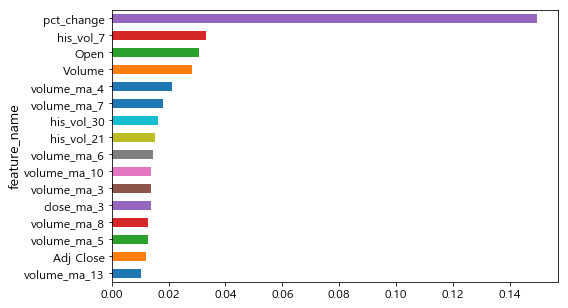

In [101]:
model, fear_importance = modelfit(alg, train["005930"], predictors, target, cv_folds=5, early_stopping_rounds=5)

In [102]:
pred = model.predict(test["005930"][predictors])

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [103]:
metrics.accuracy_score(pred, test["005930"][target])

0.8950617283950617

In [104]:
predictors.index("pct_change")

6

In [105]:
predictors.pop(6)

'pct_change'

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Model Report
Accuracy : 0.8094
AUC Score (Train): 0.891980
elapse time : 1.74


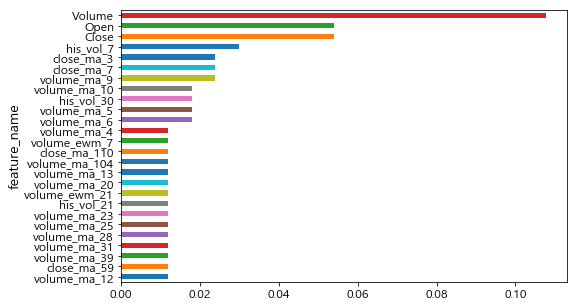

In [106]:
model, fear_importance = modelfit(alg, train["005930"], predictors, target, cv_folds=5, early_stopping_rounds=5)

In [107]:
pred = model.predict(test["005930"][predictors])
metrics.accuracy_score(pred, test["005930"][target])

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.49382716049382713

In [108]:
predictors = ['Open', 'his_vol_7', 'Volume', 'volume_ma_4']
target = 'Y2'

Model Report
Accuracy : 0.6644
AUC Score (Train): 0.741534
elapse time : 0.28


C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


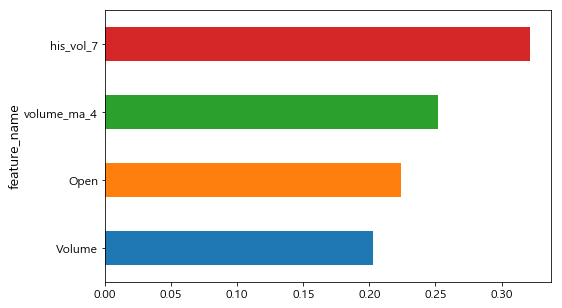

In [110]:
model, fear_importance = modelfit(alg, train["005930"], predictors, target, cv_folds=5, early_stopping_rounds=5)

In [111]:
pred = model.predict(test["005930"][predictors])
metrics.accuracy_score(pred, test["005930"][target])

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.49691358024691357

In [112]:
predictors = ['Open', 'close_ma_3', 'close_ma_5']
target = 'Y3'

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Model Report
Accuracy : 0.6829
AUC Score (Train): 0.772316
elapse time : 0.49


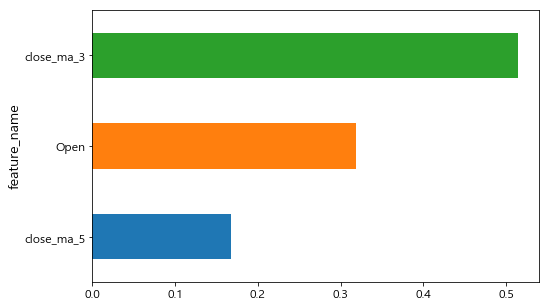

In [113]:
model, fear_importance = modelfit(alg, train["005930"], predictors, target, cv_folds=5, early_stopping_rounds=5)

In [114]:
pred = model.predict(test["005930"][predictors])
metrics.accuracy_score(pred, test["005930"][target])

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.5061728395061729